In [1]:
#Add libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [2]:
#Load data processed on the HPC

prs = pd.read_csv("../data/protein_prs_cases.csv", sep="\t", index_col=0)

prs.head()

,Group,Case,Sex,APOB.2797.56.2,APOE.2937.10.2,CRP.4337.49.2
0,A,2,2,-0.318171,-0.133883,-0.266216
1,A,2,2,0.689710,0.421410,-1.659654
2,A,2,1,-2.252077,-1.003851,-0.420168
3,A,2,2,0.689710,-0.133883,-1.053209
4,A,2,2,-0.318171,0.843965,-0.344878


              Case          Sex  APOB.2797.56.2  APOE.2937.10.2  CRP.4337.49.2
count  6244.000000  6244.000000    6.244000e+03    6.244000e+03   6.244000e+03
mean      1.686579     1.598334   -7.206916e-12   -1.933456e-10   2.802562e-10
std       0.463921     0.490274    9.998398e-01    9.998398e-01   9.998398e-01
min       1.000000     1.000000   -4.349135e+00   -6.502712e+00  -3.734828e+00
25%       1.000000     1.000000   -3.181712e-01   -1.338832e-01  -6.136645e-01
50%       2.000000     2.000000   -3.181712e-01    2.886725e-01   1.042077e-01
75%       2.000000     2.000000    6.897097e-01    8.173019e-01   7.533913e-01
max       2.000000     2.000000    1.748612e+00    1.222361e+00   3.271693e+00
Group              object
Case                int64
Sex                 int64
APOB.2797.56.2    float64
APOE.2937.10.2    float64
CRP.4337.49.2     float64
dtype: object


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1507688b0>,
      dtype=object)

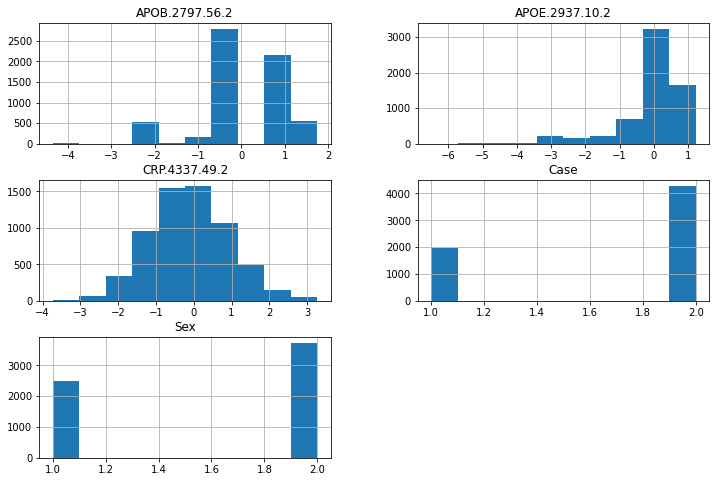

In [3]:
#Review missingness and distribution of variables

print(prs.describe())
print(prs.dtypes)

prs.hist(figsize=(12,8))

#Finding: consider whether need to further transform PRS (already normalised to Z scores - units of standard deviation)

In [27]:
#Check 3 groups and numbers in each categorical group

prs.groupby("Group").count()

,Case,Sex,APOB.2797.56.2,APOE.2937.10.2,CRP.4337.49.2
Group,,,,,
A,4492,4492,4492,4492,4492
B,1007,1007,1007,1007,1007
C,745,745,745,745,745


In [17]:
#Update case and sex from 2/1 and to dummy variables 1/0
#Case -> 1 = "AD", 0 = "CTL"
#Sex -> 1 = "Female", 0 = "Male"

if (prs["Case"].max() == 2) | (prs["Sex"].max() == 2):
    prs.loc[prs["Case"] == 1, "Case"] = 0
    prs.loc[prs["Case"] == 2, "Case"] = 1

    prs.loc[prs["Sex"] == 1, "Sex"] = 0
    prs.loc[prs["Sex"] == 2, "Sex"] = 1
else:
    print("Already updated")

print(prs[["Case", "Sex"]].describe())

print(prs.groupby("Group")["Case"].sum())

Already updated
              Case          Sex
count  6244.000000  6244.000000
mean      0.686579     0.598334
std       0.463921     0.490274
min       0.000000     0.000000
25%       0.000000     0.000000
50%       1.000000     1.000000
75%       1.000000     1.000000
max       1.000000     1.000000


Group
A    3277
B     639
C     371
Name: Case, dtype: int64

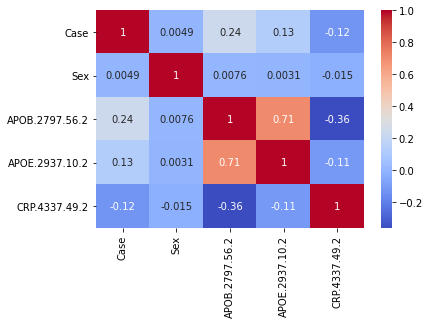

In [18]:
#Check correlation between PRS scores
sns.heatmap(prs.corr(), annot = True, cmap = "coolwarm")

#Finding: APOB and APOE are highly correlated (> 0.7). In full, multivariate models consider only selecting one.

In [91]:
#Build univariate logistic regression models with each PRS single input using sklearn and calculate classification performance metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

#COULD BE SIGNIFICANTLY REFACTORED IF WANTED TO TURN INTO UTILITY (e.g. library option, univariate vs multivariate)
def build_log_model(proteins):
    for protein in proteins:
        x_train, x_test, y_train, y_test = train_test_split(prs[protein], prs["Case"], test_size=0.25, random_state=0)
        
        logr = LogisticRegression()

        X = np.array(x_train).reshape(-1,1)
        X_test = np.array(x_test).reshape(-1,1)

        md = logr.fit(X, y_train)

        pred = md.predict(X_test)

        accuracy_sk = md.score(X_test, y_test)
        accuracy_mn = sum(pred == y_test) / y_test.count()
        auc = roc_auc_score(y_test, md.predict(X_test))

        print(protein, "Accuracy", accuracy_sk)
        #print(protein, accuracy_mn)
        tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
        sensitivity = tp / (tp + fn) #-> also recall
        specificity = tn / (tn + fp)
        precision = tp / (tp + fp)
        print(protein, "Sensitivity", sensitivity)
        print(protein, "Specificity", specificity)
        print(protein, "Precision", precision)

        probas = md.predict_proba(X_test)
        plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1], label=protein)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend(prop={'size':10}, loc='lower right')
        print(protein, "AUC", auc)
    

APOE.2937.10.2 Accuracy 0.6873798846893018
APOE.2937.10.2 Sensitivity 0.9841121495327103
APOE.2937.10.2 Specificity 0.04073319755600815
APOE.2937.10.2 Precision 0.6909448818897638
APOE.2937.10.2 AUC 0.5124226735443592
APOB.2797.56.2 Accuracy 0.6841768097373478
APOB.2797.56.2 Sensitivity 0.9327102803738317
APOB.2797.56.2 Specificity 0.1425661914460285
APOB.2797.56.2 Precision 0.7033121916842847
APOB.2797.56.2 AUC 0.5376382359099301
CRP.4337.49.2 Accuracy 0.6848174247277387
CRP.4337.49.2 Sensitivity 0.9990654205607477
CRP.4337.49.2 Specificity 0.0
CRP.4337.49.2 Precision 0.6852564102564103
CRP.4337.49.2 AUC 0.4995327102803738


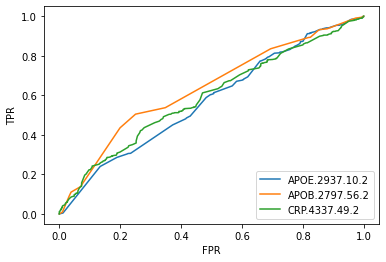

In [92]:
PROTEINS = ["APOE.2937.10.2", "APOB.2797.56.2", "CRP.4337.49.2"]
build_log_model(PROTEINS)

#NOTE - interesting that logr seems to apply method inplace, so could use md and logr interchangeably unless wanted to create copies

#Finding - Individual proteins not robust classifiers as AUC similar to chance. 
    #Classification weakness appears to be driven by inability to identify true negatives - effectively classifying everything as AD (training data does have high proportion of cases, much higher than a typical population)


In [108]:
#Build univariate logistic regression model using statsmodel (provides R^2 and p-values)
import statsmodels.api as sm

for protein in PROTEINS:
        x_train, x_test, y_train, y_test = train_test_split(prs[protein], prs["Case"], test_size=0.25, random_state=0)
        #manually add intercept
        x_train = sm.add_constant(x_train)
        
        sm_md = sm.Logit(y_train, x_train).fit()
        
        print(sm_md.summary())
        
        x_test = sm.add_constant(x_test)
        
        sm_pred = sm_md.predict(x_test)
        
        auc = roc_auc_score(y_test, sm_pred)
        print(protein,"AUC", auc)
        
        


Optimization terminated successfully.
         Current function value: 0.612992
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   Case   No. Observations:                 4683
Model:                          Logit   Df Residuals:                     4681
Method:                           MLE   Df Model:                            1
Date:                Thu, 06 Aug 2020   Pseudo R-squ.:                 0.01372
Time:                        16:08:20   Log-Likelihood:                -2870.6
converged:                       True   LL-Null:                       -2910.6
Covariance Type:            nonrobust   LLR p-value:                 4.042e-19
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7945      0.032     24.946      0.000       0.732       0.857
APOE.2937.10.2   

All PRS Accuracy 0.6828955797565663
All PRS Sensitivity 0.9345794392523364
All PRS Specificity 0.13441955193482688
All PRS Precision 0.7017543859649122
All PRS AUC 0.5344994955935817


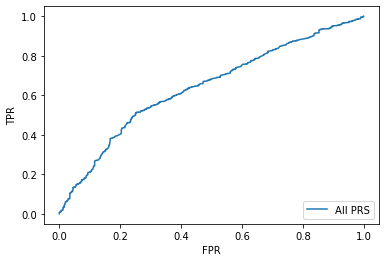

In [117]:
#Build multivariate logistic regression model with all 3 PRS (sklearn)

x_train, x_test, y_train, y_test = train_test_split(prs.iloc[:, 3:], prs["Case"], test_size=0.25, random_state=0)

logr = LogisticRegression()

X = np.array(x_train).reshape(-3,3)
X_test = np.array(x_test).reshape(-3,3)

md = logr.fit(X, y_train)

pred = md.predict(X_test)

accuracy_sk = md.score(X_test, y_test)
accuracy_mn = sum(pred == y_test) / y_test.count()
auc = roc_auc_score(y_test, md.predict(X_test))

print("All PRS", "Accuracy", accuracy_sk)
#print(protein, accuracy_mn)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
sensitivity = tp / (tp + fn) #-> also recall
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
print("All PRS", "Sensitivity", sensitivity)
print("All PRS", "Specificity", specificity)
print("All PRS", "Precision", precision)

probas = md.predict_proba(X_test)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1], label="All PRS")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(prop={'size':10}, loc='lower right')
print("All PRS", "AUC", auc)

In [128]:
#Build multivariate logistic regression model with all 3 PRS (stats model)

x_train_sm = sm.add_constant(x_train)
        
sm_md_all = sm.Logit(y_train, x_train_sm).fit()

print(sm_md_all.summary())


Optimization terminated successfully.
         Current function value: 0.589579
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   Case   No. Observations:                 4683
Model:                          Logit   Df Residuals:                     4679
Method:                           MLE   Df Model:                            3
Date:                Thu, 06 Aug 2020   Pseudo R-squ.:                 0.05139
Time:                        16:24:16   Log-Likelihood:                -2761.0
converged:                       True   LL-Null:                       -2910.6
Covariance Type:            nonrobust   LLR p-value:                 1.536e-64
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8368      0.033     25.235      0.000       0.772       0.902
APOB.2797.56.2   